In [1]:
# Import the libraries
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from odc.stac import configure_rio, stac_load
import dask.distributed
import dask.utils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Set up Dask client for parallel processing
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)

# Configure rio with dynamic resolution
resolution = 20
memory_limit = dask.utils.parse_bytes(client.cluster.workers[0].memory_manager.memory_limit)
SHRINK = 4
if memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # Adjust chunk size if memory is limited

resolution = resolution * SHRINK

/opt/anaconda3/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60270 instead
  warnings.warn(


In [3]:
# # # Define the area of interest (AOI) near Jonah Bay, Alaska.
area_of_interest = {
        "type": "Polygon",
        "coordinates": [
            [
             [-148.56536865234375, 60.80072385643073],
             [-147.44338989257812, 60.80072385643073],
             [-147.44338989257812, 61.18363894915102],
             [-148.56536865234375, 61.18363894915102],
             [-148.56536865234375, 60.80072385643073]  # Closing point 
            ]
        ],
   }

#  time span of 10 years
time_of_interest = "2023-06-01/2023-09-01"

# Query the catalog for the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    #query={"eo:cloud_cover": {"lt": 10}}
)
items = list(search.items())
print(f"Returned {len(items)} Items")

Returned 55 Items


In [4]:
xx = stac_load(
    items,
    chunks={"x": 1024 * SHRINK, "y": 1024 * SHRINK},  # Dynamically adjust chunk size
    patch_url=planetary_computer.sign,
    resolution=resolution,
    dtype="uint16",  # Handle missing data by marking nodata values
    nodata=0
)

# Display loaded data
print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 831MB
Dimensions:      (y: 687, x: 687, time: 55)
Coordinates:
  * y            (y) float64 5kB 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 5kB 3.999e+05 4.001e+05 ... 5.095e+05 5.097e+05
    spatial_ref  int32 4B 32606
  * time         (time) datetime64[ns] 440B 2023-06-01T21:35:29.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    B01          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    B02          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    B03          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    B04          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    B05          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    B12          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    B8A          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    SCL          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    WVP          (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>
    visual       (time, y, x) uint16 52MB dask.array<chunksize=(1, 687, 687), meta=np.ndarray>

In [5]:
# Function to convert data to float and handle missing nodata values
def to_float(xx, nodata_value=None):
    _xx = xx.astype("float32")  # Convert data to float32 for precision
    if nodata_value is None:
        nodata_value = _xx.attrs.pop("nodata", None)  # Fetch nodata value if exists
    if nodata_value is not None:
        return _xx.where(xx != nodata_value)  # Replace nodata with NaN
    return _xx

# Convert specific bands to float32 and handle missing data
b05 = to_float(xx.B05)  # Red-Edge band
b04 = to_float(xx.B04)  # Red band

In [6]:
# Calculate NDCI with small constant to avoid division by zero
ndci = (b05 - b04) / (b05 + b04 + 1e-6)

# Apply Min-Max normalization to scale NDCI between 0 and 1
ndci = (ndci - ndci.min()) / (ndci.max() - ndci.min())

chl = 826.57*(ndci**3) - 176.43*(ndci**2) + 19*(ndci) + 4.071

In [8]:
time_dim = chl['time']

#split 70% for training and  30% for testing
split_index = int(0.7 * len(time_dim))

#split the dataset based on the time dimension
train_data = chl.isel(time=slice(0, split_index))  # first 70% of the time steps
test_data = chl.isel(time=slice(split_index, len(time_dim)))  #

In [9]:
train_data

<xarray.DataArray (time: 38, y: 687, x: 687)> Size: 72MB
dask.array<getitem, shape=(38, 687, 687), dtype=float32, chunksize=(1, 687, 687), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 5kB 3.999e+05 4.001e+05 ... 5.095e+05 5.097e+05
    spatial_ref  int32 4B 32606
  * time         (time) datetime64[ns] 304B 2023-06-01T21:35:29.024000 ... 20...

In [10]:
test_data

<xarray.DataArray (time: 17, y: 687, x: 687)> Size: 32MB
dask.array<getitem, shape=(17, 687, 687), dtype=float32, chunksize=(1, 687, 687), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 6.8e+06 6.8e+06 6.8e+06 ... 6.69e+06 6.69e+06
  * x            (x) float64 5kB 3.999e+05 4.001e+05 ... 5.095e+05 5.097e+05
    spatial_ref  int32 4B 32606
  * time         (time) datetime64[ns] 136B 2023-08-04T21:15:19.024000 ... 20...

In [11]:
# data_array = test_data['chl']  
test = test_data.fillna(0)

data_array = test.values 

#reshape Dataarray to 2d and flatten size into a single column
test_data = data_array.reshape(-1, 1)
test_data.shape

(8023473, 1)

In [12]:
train_data_clean = train_data.fillna(0)  #replace NaN values with 0 

# train_data_array = train_data_clean['chl']  

#convert the DataArray to a NumPy array
train_data_np = train_data_clean.values

#reshape Dataarray to 2d and flatten size into a single column
train_data = train_data_np.reshape(-1, 1) #(row, col)
train_data

array([[ 0.     ],
       [ 0.     ],
       [ 0.     ],
       ...,
       [76.85118],
       [76.22952],
       [76.2549 ]], dtype=float32)

In [13]:
train_data.shape

(17934822, 1)

Root Mean Squared Error: 39.337235605177604


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


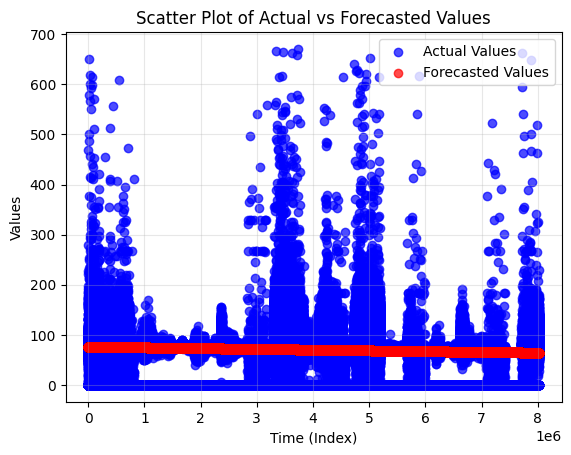

In [17]:
from sklearn_xarray import wrap
from pmdarima.arima import ARIMA
from sklearn.metrics import mean_squared_error

arima_model = ARIMA(order=(1, 1, 1)) #(2, 1, 2) is bad

#wrap the ARIMA instance with sklearn-xarray
model = wrap(arima_model)

model.fit(train_data)

# forecast test data
forecast = model.predict(len(test_data))  

actual_values = test_data

#mean squared error 
mse = mean_squared_error(actual_values, forecast)
# print(f"Mean Squared Error: {mse}")

#get root mean squared error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

x = np.arange(len(actual_values))

# Plot actual values as scatter points
plt.scatter(x, actual_values, color='blue', label='Actual Values', alpha=0.7)

# Plot forecast values as scatter points
plt.scatter(x, forecast, color='red', label='Forecasted Values', alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Time (Index)')
plt.ylabel('Values')
plt.title('Scatter Plot of Actual vs Forecasted Values')
plt.legend()

# Show grid for better visualization
plt.grid(alpha=0.3)

# Show the plot
plt.show()
